In [1]:
import os
import pandas
import json
import pickle

import numpy
import math
import scipy.stats

%matplotlib widget
import matplotlib
import matplotlib.pyplot
import seaborn

import datetime
import pytz

import activity_experiments_python.scenario_management as SFM
import activity_experiments_python.ampconfig_management as ACM
import activity_experiments_python.signalsconfig_management as SCM
import activity_experiments_python.actuation_management as AM

In [2]:
# CONSTANTS
FPS             = 30 # Hz
NB_ACTS         = 8
MAPPING         = {0:[0,0], 1:[0,1], 2:[0,2], 3:[0,3], 4:[1,3], 5:[1,2], 6:[1,1], 7:[1,0]}
MAPPING_PLOT    = {0:[1,0], 1:[1,1], 2:[1,2], 3:[1,3], 4:[0,3], 5:[0,2], 6:[0,1], 7:[0,0]}
ACTUATION_DUR   = 15 # secs

# PATHS
root_path = "/Users/matthieu/Documents/proto3/Graz2023/May/activity/continuous/"

conf_path = root_path + 'configs/'
amp_config_file = conf_path + 'amp2config/config.json'
sig_config_file = conf_path + 'signals/signals_config.json'
sce_alloc_file = root_path + 'processed_data/scenarios_allocation.json'

res_path = root_path + 'processed_data/acts/'
leds_res_path = res_path + 'leds/'
acts_res_path = res_path + 'acts/'

# CONFIGS
amp_conf        = ACM.extract_amp_config(amp_config_file)
sig_conf        = SCM.extract_signals_config(sig_config_file)

f = open(sce_alloc_file, "r")
sce_alloc = json.load(f)
f.close()


# DATA
file_list = [x for x in os.listdir(acts_res_path) if x.endswith('acts.pickle')]
exps_times_list = sorted(list(set([x.split('_')[0] for x in file_list])))

resdata = [] 
for exp_id, exp_time in enumerate(exps_times_list):
    datapt = {}
    datapt['time'] = pytz.utc.localize(datetime.datetime.strptime(exp_time[:-3], '%y%m%dT%H%M%S'))
    datapt['time_hr'] = exp_time
    datapt['act_path'] = acts_res_path
    datapt['led_path'] = leds_res_path
    for i in range(0, NB_ACTS+1):
        if i == NB_ACTS:
            ind = 'a'
        else :
            ind = str(i)
        datapt['z'+ind+'_actname'] = exp_time+'_z'+ind+'_acts.pickle'
    datapt['led0name'] = exp_time + '_led0.pickle'
    datapt['led1name'] = exp_time + '_led1.pickle'

    # print(sce_alloc[exp_time])
    sce = SFM.extract_scenario_data_from_log(root_path + sce_alloc[exp_time])
    trig0_val = numpy.min(sce[2])
    trig1_val = numpy.min(sce[3])
    
    datapt['trig0'] = trig0_val
    datapt['trig1'] = trig1_val
    if trig0_val == 11 :
        datapt['sig1'] = {}
        datapt['sig2'] = {}
    else :
        datapt['sig1'] = sig_conf['SB0'][str(trig0_val)]['1']
        datapt['sig2'] = sig_conf['SB0'][str(trig0_val)]['2']

    if trig1_val == 11 :
        datapt['sig3'] = {}
        datapt['sig4'] = {}
    else :
        datapt['sig3'] = sig_conf['SB1'][str(trig1_val)]['1']
        datapt['sig4'] = sig_conf['SB1'][str(trig1_val)]['2']

    list_of_freqs = []
    for i in range(0, 8):
        ind = str(i)
        datapt['z'+ind+'_sig'] = [x for x in amp_conf.keys() if i in amp_conf[x]][0]
        if not(datapt['z'+ind+'_sig'] == 'gnd') and not(datapt[datapt['z'+ind+'_sig']] == {}):
            datapt['z'+ind+'_freq'] = datapt[datapt['z'+ind+'_sig']]['frequency']
            list_of_freqs.append(datapt['z'+ind+'_freq'])
        else :
            datapt['z'+ind+'_freq'] = None

    if trig1_val*trig0_val == 121 :
        datapt['frequency'] = 'Ctrl'
    elif trig1_val >= trig0_val:
        datapt['frequency'] = sig_conf['SB0'][str(trig0_val)]
    else :
        datapt['frequency'] = sig_conf['SB1'][str(trig1_val)]
    
    # sanity check
    if len(set(list_of_freqs)) > 1:
        print('Multiple frequencies at the same time')
        datapt['frequency'] = 'Problem'
    elif len(set(list_of_freqs)) == 1:
        datapt['frequency'] = list_of_freqs[0]
    else :
        datapt['frequency'] = 'Ctrl'
        
    resdata.append(datapt)

metadata = pandas.DataFrame.from_dict(resdata)
metadata

,time,time_hr,act_path,led_path,z0_actname,z1_actname,z2_actname,z3_actname,z4_actname,z5_actname,...,z3_freq,z4_sig,z4_freq,z5_sig,z5_freq,z6_sig,z6_freq,z7_sig,z7_freq,frequency
0,2023-05-28 08:00:12+00:00,230528T080012UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230528T080012UTC_z0_acts.pickle,230528T080012UTC_z1_acts.pickle,230528T080012UTC_z2_acts.pickle,230528T080012UTC_z3_acts.pickle,230528T080012UTC_z4_acts.pickle,230528T080012UTC_z5_acts.pickle,...,NaN,sig2,1750.0,sig2,1750.0,sig4,1750.0,sig4,1750.0,1750
1,2023-05-28 08:02:11+00:00,230528T080211UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230528T080211UTC_z0_acts.pickle,230528T080211UTC_z1_acts.pickle,230528T080211UTC_z2_acts.pickle,230528T080211UTC_z3_acts.pickle,230528T080211UTC_z4_acts.pickle,230528T080211UTC_z5_acts.pickle,...,NaN,sig2,NaN,sig2,NaN,sig4,NaN,sig4,NaN,1500
2,2023-05-28 08:04:11+00:00,230528T080411UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230528T080411UTC_z0_acts.pickle,230528T080411UTC_z1_acts.pickle,230528T080411UTC_z2_acts.pickle,230528T080411UTC_z3_acts.pickle,230528T080411UTC_z4_acts.pickle,230528T080411UTC_z5_acts.pickle,...,NaN,sig2,NaN,sig2,NaN,sig4,NaN,sig4,NaN,Ctrl
3,2023-05-28 08:06:11+00:00,230528T080611UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230528T080611UTC_z0_acts.pickle,230528T080611UTC_z1_acts.pickle,230528T080611UTC_z2_acts.pickle,230528T080611UTC_z3_acts.pickle,230528T080611UTC_z4_acts.pickle,230528T080611UTC_z5_acts.pickle,...,1250.0,sig2,NaN,sig2,NaN,sig4,NaN,sig4,NaN,1250
4,2023-05-28 08:08:11+00:00,230528T080811UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230528T080811UTC_z0_acts.pickle,230528T080811UTC_z1_acts.pickle,230528T080811UTC_z2_acts.pickle,230528T080811UTC_z3_acts.pickle,230528T080811UTC_z4_acts.pickle,230528T080811UTC_z5_acts.pickle,...,NaN,sig2,NaN,sig2,NaN,sig4,2000.0,sig4,2000.0,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,2023-06-12 10:10:11+00:00,230612T101011UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230612T101011UTC_z0_acts.pickle,230612T101011UTC_z1_acts.pickle,230612T101011UTC_z2_acts.pickle,230612T101011UTC_z3_acts.pickle,230612T101011UTC_z4_acts.pickle,230612T101011UTC_z5_acts.pickle,...,NaN,sig2,1500.0,sig2,1500.0,sig4,1500.0,sig4,1500.0,1500
803,2023-06-12 10:12:11+00:00,230612T101211UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230612T101211UTC_z0_acts.pickle,230612T101211UTC_z1_acts.pickle,230612T101211UTC_z2_acts.pickle,230612T101211UTC_z3_acts.pickle,230612T101211UTC_z4_acts.pickle,230612T101211UTC_z5_acts.pickle,...,1000.0,sig2,1000.0,sig2,1000.0,sig4,1000.0,sig4,1000.0,1000
804,2023-06-12 10:14:11+00:00,230612T101411UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230612T101411UTC_z0_acts.pickle,230612T101411UTC_z1_acts.pickle,230612T101411UTC_z2_acts.pickle,230612T101411UTC_z3_acts.pickle,230612T101411UTC_z4_acts.pickle,230612T101411UTC_z5_acts.pickle,...,NaN,sig2,1750.0,sig2,1750.0,sig4,NaN,sig4,NaN,1750
805,2023-06-12 10:16:11+00:00,230612T101611UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230612T101611UTC_z0_acts.pickle,230612T101611UTC_z1_acts.pickle,230612T101611UTC_z2_acts.pickle,230612T101611UTC_z3_acts.pickle,230612T101611UTC_z4_acts.pickle,230612T101611UTC_z5_acts.pickle,...,1250.0,sig2,NaN,sig2,NaN,sig4,NaN,sig4,NaN,1250


In [3]:
def euclidean_dist(x, y):
    return (x[0]-y[0])**2 + (x[1]-y[1])**2

def find_closest_act(dtpt, i_act):
    dist_init = 100
    closest_act = 10
    for i in range(NB_ACTS):
        ind = str(i)
        if dtpt['act_z'+ind] == 1 :
            dist = euclidean_dist(MAPPING[i_act], MAPPING[i])
            if dist < dist_init :
                closest_act = i
                dist_init = dist
                
    return closest_act, dist_init

In [4]:
# Activity computation
long_interval_length    = 15 # seconds 
short_interval_length   = 5 # seconds 

NORMALIZATION_TYPE = 'first' # 'max' # 

lil_dt = datetime.timedelta(seconds=long_interval_length)
sil_dt = datetime.timedelta(seconds=short_interval_length)

fields_to_keep = ['time', 'time_hr', 'frequency', 'trig0', 'trig1']
resdata = []
for exp_id, exp in metadata.iterrows():
    datapoint = {}
    for key in fields_to_keep:
        datapoint[key] = exp[key]

    sum_acts = 0
    for i in range(0, NB_ACTS):
        if not(math.isnan(exp['z'+str(i)+'_freq'])):
            datapoint['act_z'+str(i)] = 1
            sum_acts += 1
        else :
            datapoint['act_z'+str(i)] = 0
    for i in range(0, NB_ACTS):
        close_act, dist = find_closest_act(datapoint, i)
        datapoint['act_z'+str(i)+'_closest_act_dist'] = dist
        if datapoint['trig0'] == 11 and datapoint['trig1'] == 11:
            datapoint['act_z'+str(i)+'_closest_act_dist'] = 'ctrl'
    
    datapoint['nb_acts_active'] = sum_acts
    led0_signal = pandas.read_pickle(exp.led_path + exp.led0name)
    led1_signal = pandas.read_pickle(exp.led_path + exp.led1name)
    
    sce = SFM.extract_scenario_data_from_log(root_path + sce_alloc[datapoint['time_hr']])

    if exp.trig0*exp.trig1 == 121:
        ts = 0
        ct = 17
    elif exp.trig0 == 11:
        ts = SFM.compute_time_shift(led1_signal.value, sce[1], plot=False, save_plot_fname=None, fps=FPS)
        ct = 1/FPS*next((i for i, x in enumerate(list(sce[1])) if x==0), None) + ts/FPS
    elif exp.trig1 == 11:
        ts = SFM.compute_time_shift(led0_signal.value, sce[0], plot=False, save_plot_fname=None, fps=FPS)
        ct = 1/FPS*next((i for i, x in enumerate(list(sce[0])) if x==0), None) + ts/FPS
    else:
        ts0 = SFM.compute_time_shift(led0_signal.value, sce[0], plot=False, save_plot_fname=None, fps=FPS)
        ts1 = SFM.compute_time_shift(led1_signal.value, sce[1], plot=False, save_plot_fname=None, fps=FPS)
        ts = (ts0 + ts1) / 2
        ct = 1/FPS*next((i for i, x in enumerate(list(sce[0])) if x==0), None) + ts/FPS

    datapoint['timeshift'] = ts
    datapoint['change_time_on'] = datapoint['time'] + datetime.timedelta(seconds=ct)
    datapoint['change_time_off'] = datapoint['time'] + datetime.timedelta(seconds=ct+15)

    for i in range(0, NB_ACTS):
        ind = str(i)
        act_signal = pandas.read_pickle(exp.act_path + exp['z'+ind+'_actname'])

        # 15 minutes analysis ! 
        # Before actuation
        actsignal_B = act_signal[(act_signal.local_ts > datapoint['change_time_on']-lil_dt)]
        actsignal_B = actsignal_B[(actsignal_B.local_ts < datapoint['change_time_on'])]

        # During actuation
        actsignal_D = act_signal[(act_signal.local_ts > datapoint['change_time_on'])]
        actsignal_D = actsignal_D[(actsignal_D.local_ts < datapoint['change_time_off'])]

        # Right after actuation
        actsignal_A1 = act_signal[(act_signal.local_ts > datapoint['change_time_off'])]
        actsignal_A1 = actsignal_A1[(actsignal_A1.local_ts < datapoint['change_time_off']+lil_dt)]

        # moments after actuation
        actsignal_A2 = act_signal[(act_signal.local_ts > datapoint['change_time_off']+lil_dt)]
        actsignal_A2 = actsignal_A2[(actsignal_A2.local_ts < datapoint['change_time_off']+2*lil_dt)]

        datapoint['z'+ind+'_B_ave']     = actsignal_B.value.mean()
        datapoint['z'+ind+'_D_ave']     = actsignal_D.value.mean()
        datapoint['z'+ind+'_A1_ave']    = actsignal_A1.value.mean()
        datapoint['z'+ind+'_A2_ave']    = actsignal_A2.value.mean()

        datapoint['z'+ind+'_relative_D']    = datapoint['z'+ind+'_D_ave'] / datapoint['z'+ind+'_B_ave']
        datapoint['z'+ind+'_relative_A1']   = datapoint['z'+ind+'_A1_ave'] / datapoint['z'+ind+'_B_ave']
        datapoint['z'+ind+'_relative_A2']   = datapoint['z'+ind+'_A2_ave'] / datapoint['z'+ind+'_B_ave']

        # 5 minutes bins
        all_bins_vals = []
        for j in range(-3, 9): # number of 5 mins bins in a minute
            act_signal_bin = act_signal[(act_signal.local_ts > datapoint['change_time_on']+j*sil_dt)]
            act_signal_bin = act_signal_bin[(act_signal_bin.local_ts < datapoint['change_time_on']+(j+1)*sil_dt)]
            datapoint['z'+ind+'_bin'+str(j+3)+'_ave'] = act_signal_bin.value.mean()
            all_bins_vals.append(act_signal_bin.value.mean())
        all_bins_vals = numpy.array(all_bins_vals)
        # all_bins_vals = all_bins_vals-numpy.min(all_bins_vals)
        # all_bins_vals = all_bins_vals/numpy.max(all_bins_vals)
        if NORMALIZATION_TYPE == 'first':
            all_bins_vals = all_bins_vals/all_bins_vals[0]
        else :
            all_bins_vals = all_bins_vals/numpy.max(all_bins_vals)
        for j in range(-3, 9):
            datapoint['z'+ind+'_bin'+str(j+3)+'_rel'] =  all_bins_vals[j+3]

    
    # print(datapoint)
    resdata.append(datapoint)

data = pandas.DataFrame.from_dict(resdata)
data

,time,time_hr,frequency,trig0,trig1,act_z0,act_z1,act_z2,act_z3,act_z4,...,z7_bin2_rel,z7_bin3_rel,z7_bin4_rel,z7_bin5_rel,z7_bin6_rel,z7_bin7_rel,z7_bin8_rel,z7_bin9_rel,z7_bin10_rel,z7_bin11_rel
0,2023-05-28 08:00:12+00:00,230528T080012UTC,1750,8,8,0,0,0,0,1,...,1.057048,0.438723,0.326368,0.483499,0.663765,0.567910,0.582172,0.772803,1.159701,1.421973
1,2023-05-28 08:02:11+00:00,230528T080211UTC,1500,2,11,1,1,0,0,0,...,1.247224,0.634385,0.518742,1.030560,1.578432,1.265032,0.917225,0.852699,1.070793,1.191382
2,2023-05-28 08:04:11+00:00,230528T080411UTC,Ctrl,11,11,0,0,0,0,0,...,1.073495,0.905094,0.951742,0.877307,0.916102,0.967313,0.919323,0.997248,1.246795,0.803611
3,2023-05-28 08:06:11+00:00,230528T080611UTC,1250,11,1,0,0,1,1,0,...,1.369677,1.346022,1.158136,1.197204,0.812688,0.585161,0.551756,0.668100,1.177133,0.986452
4,2023-05-28 08:08:11+00:00,230528T080811UTC,2000,4,9,1,1,0,0,0,...,0.876194,0.487155,0.418494,0.510894,1.067787,0.853934,0.771083,0.970612,0.989240,0.778077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,2023-06-12 10:10:11+00:00,230612T101011UTC,1500,7,7,0,0,0,0,1,...,0.978182,0.258995,0.375366,0.484671,0.615525,0.643819,0.506167,0.599726,0.597818,0.770831
803,2023-06-12 10:12:11+00:00,230612T101211UTC,1000,10,10,1,1,1,1,1,...,0.795478,0.325615,0.431910,0.571382,0.770369,0.631657,0.619465,0.796418,0.791715,0.727026
804,2023-06-12 10:14:11+00:00,230612T101411UTC,1750,8,11,0,0,0,0,1,...,1.177154,0.541144,0.947432,0.916160,1.208761,0.947600,1.219451,1.353720,0.983400,1.221798
805,2023-06-12 10:16:11+00:00,230612T101611UTC,1250,1,1,1,1,1,1,0,...,0.964656,0.883424,0.745757,0.623853,0.734305,1.312654,1.088867,1.106607,1.088482,1.072362


## All exp analysis plots

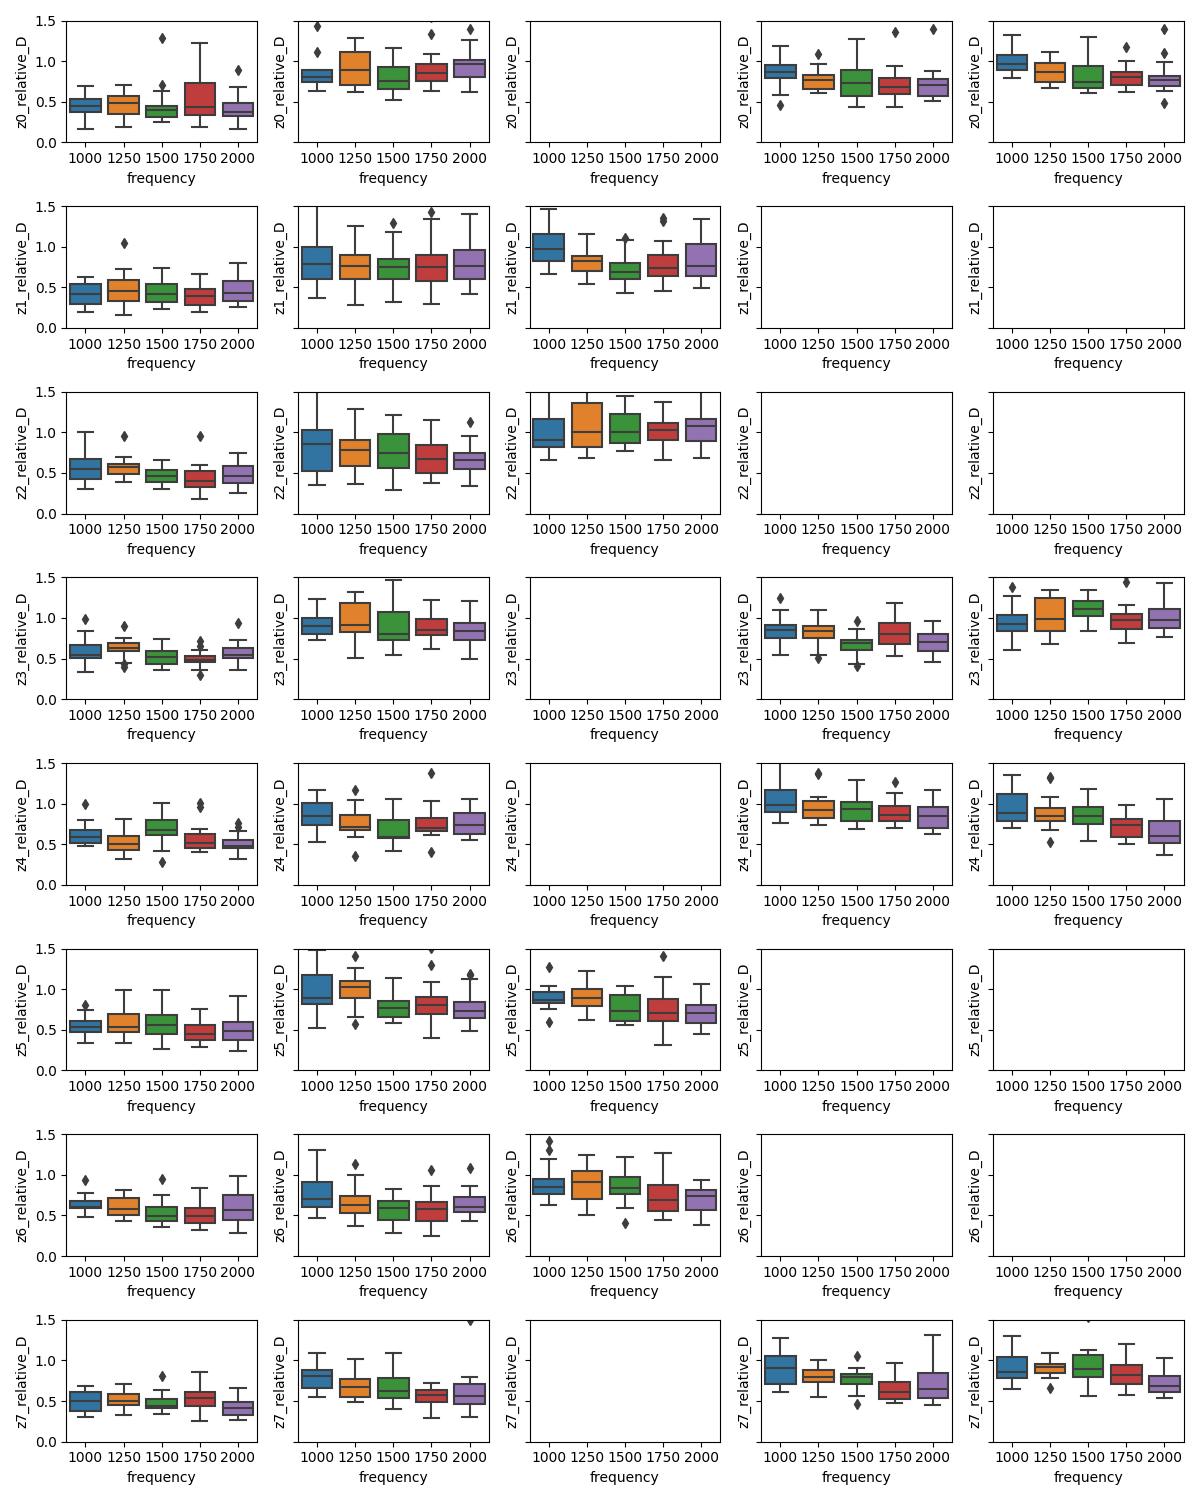

In [5]:
frequencies = [1000, 1250, 1500, 1750, 2000]
dist_to_act = [0, 1, 2, 4, 5]#, 9, 10]

dataset = data[data.nb_acts_active == 2]
fig, ax = matplotlib.pyplot.subplots(NB_ACTS, len(dist_to_act), figsize=(12, 15), sharey=True)
for act in range(NB_ACTS):
    ind = str(act)
    # data_act = data[data['act_z'+ind]==1]
    # data_noact = data[data['act_z'+ind]==0]

    for dist_id, dist in enumerate(dist_to_act):
        data_to_consider = dataset[dataset['act_z'+ind+'_closest_act_dist'] == dist]
        seaborn.boxplot(data=data_to_consider, y='z'+ind+'_relative_D', x='frequency', ax=ax[act, dist_id], order=frequencies)

ax[0,0].set_ylim([0, 1.5])
fig.tight_layout()

## 5 seconds analysis plots

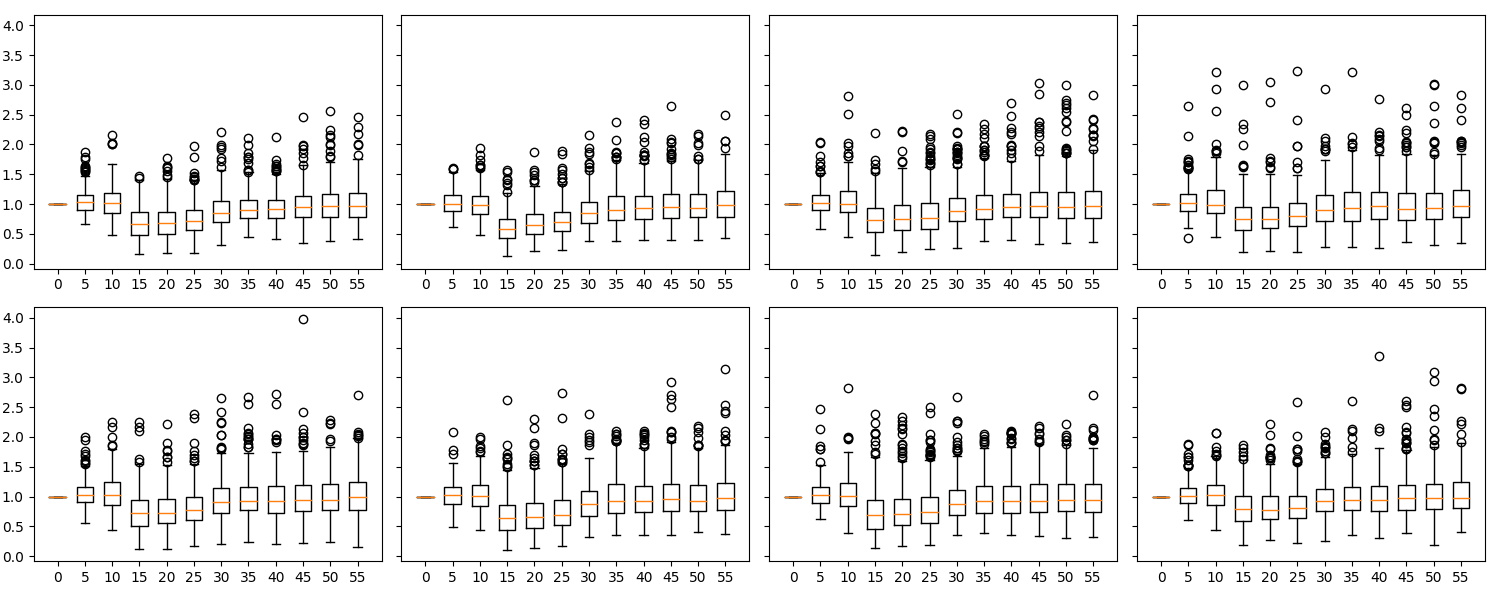

In [6]:
cmap = matplotlib.cm.get_cmap('rainbow') 

dataset = data[data.nb_acts_active == 2]
fig, ax = matplotlib.pyplot.subplots(2, 4, figsize=(15, 6), sharey=True)
for act in range(NB_ACTS):
    ind = str(act)
    # data_act = data[data['act_z'+ind]==1]
    # data_noact = data[data['act_z'+ind]==0]

    data_to_consider = dataset[dataset['act_z'+ind+'_closest_act_dist'] == 0]
    for j in range(-3, 9):
        # print(dataset)
        # print('z'+ind+'_bin'+str(j+3)+'_ave')
        ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].boxplot(dataset['z'+ind+'_bin'+str(j+3)+'_rel'].values, positions=[(j+3)*5], widths=[3])#, c=cmap(float(j+3)/12), marker='+')
    # seaborn.boxplot(data=data_to_consider, y='z'+ind+'_relative_A2', x='frequency', ax=ax[act, dist_id], order=frequencies)
    
# ax[0,0].set_ylim([0, 1.5])
fig.tight_layout()

# Figures

[[0.40492313 0.6961878  0.71751278]
 [0.35898347 0.62722839 0.8035662 ]
 [0.42186467 0.69991067 1.00819925]
 [0.49336368 0.84159256 0.84536547]
 [0.5202642  0.67645963 0.82648833]
 [0.47398704 0.70033972 0.81161213]
 [0.4326717  0.5437656  0.79220363]
 [0.41292559 0.56815835 0.71399417]]
[0.43987294 0.66920534 0.81486775]


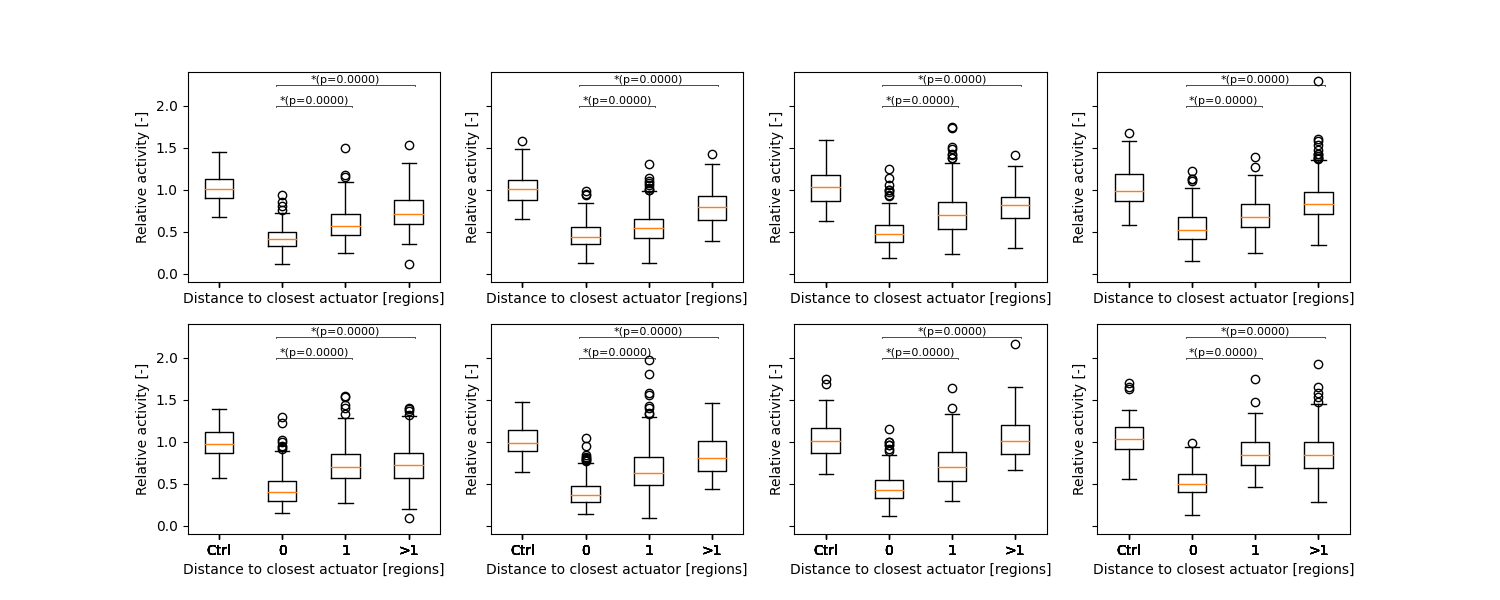

In [7]:
fig, ax = matplotlib.pyplot.subplots(2, 4, figsize=(15, 6), sharey=True, sharex=True)

# dataset = data[data.frequency == 1000]
dataset = data[data.nb_acts_active != 0]

levels = numpy.zeros((8,3))
for act in range(NB_ACTS):
    ind = str(act)
    
    data_ctrl           = data[data.frequency == 'Ctrl']['z'+ind+'_relative_D']
    data_dist0          = dataset[dataset['act_z'+ind+'_closest_act_dist'] == 0]['z'+ind+'_relative_D']
    data_dist1          = dataset[dataset['act_z'+ind+'_closest_act_dist'] == 1]['z'+ind+'_relative_D']
    data_dist_above1    = dataset[dataset['act_z'+ind+'_closest_act_dist'] >  1]['z'+ind+'_relative_D']

    bplot = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].boxplot([data_ctrl, data_dist0, data_dist1, data_dist_above1], positions=[0,1,2,3], labels=['Ctrl', '0', '1', '>1'])
    # seaborn.boxplot(data=dataset, x='act_z'+ind+'_closest_act_dist', y='z'+ind+'_bin3_rel', hue='act_z'+ind+'_closest_act_dist', ax=ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]])
    # .scatter(dataset['z'+ind+'_bin0_rel'].values, positions=[(j+3)*5], widths=[3])
    
    levels[act, 0] = data_dist0.median()
    levels[act, 1] = data_dist1.median()
    levels[act, 2] = data_dist_above1.median()

    RStest_0_1 = scipy.stats.ranksums(data_dist0, data_dist1)
    RStest_0_a1 = scipy.stats.ranksums(data_dist0, data_dist_above1)

    # print(ind, len(data_dist0), len(data_dist1), len(data_dist_above1))
    # print(ind, scipy.stats.ranksums(data_dist0['z'+ind+'_bin3_rel'], data_dist1['z'+ind+'_bin3_rel']))
    # print(ind, scipy.stats.ranksums(data_dist0['z'+ind+'_bin3_rel'], data_dist_above1['z'+ind+'_bin3_rel']))

    if NORMALIZATION_TYPE == 'first':
        YLIMS       = [-0.1, 2.4]
        SB_LEVEL1   = 2.0
        SB_LEVEL2   = 2.25
    else :
        YLIMS       = [-0.1, 1.4]
        SB_LEVEL1   = 1.1
        SB_LEVEL2   = 1.25

    # axis limits
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_xlim([-0.5, 3.5])
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_ylim(YLIMS)

    # axis labels
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_xlabel('Distance to closest actuator [regions]')
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_ylabel('Relative activity [-]')

    # Significance bars
    sb_level    = SB_LEVEL1
    sb_width    = 1.2
    sb_height   = 0.02
    sb_positions= 1.5
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].plot([sb_positions-sb_width/2, sb_positions-sb_width/2, sb_positions+sb_width/2, sb_positions+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].text(sb_positions, sb_level+0.015, '{}(p={:1.4f})'.format(['' if  RStest_0_1[1]>0.05 else '*'][0], RStest_0_1[1]), fontsize=8, horizontalalignment='center')

    sb_level    = SB_LEVEL2
    sb_width    = 2.2
    sb_height   = 0.02
    sb_positions= 2
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].plot([sb_positions-sb_width/2, sb_positions-sb_width/2, sb_positions+sb_width/2, sb_positions+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].text(sb_positions, sb_level+0.015, '{}(p={:1.4f})'.format(['' if  RStest_0_a1[1]>0.05 else '*'][0], RStest_0_a1[1]), fontsize=8, horizontalalignment='center')

print(levels)
print(levels.mean(axis=0))

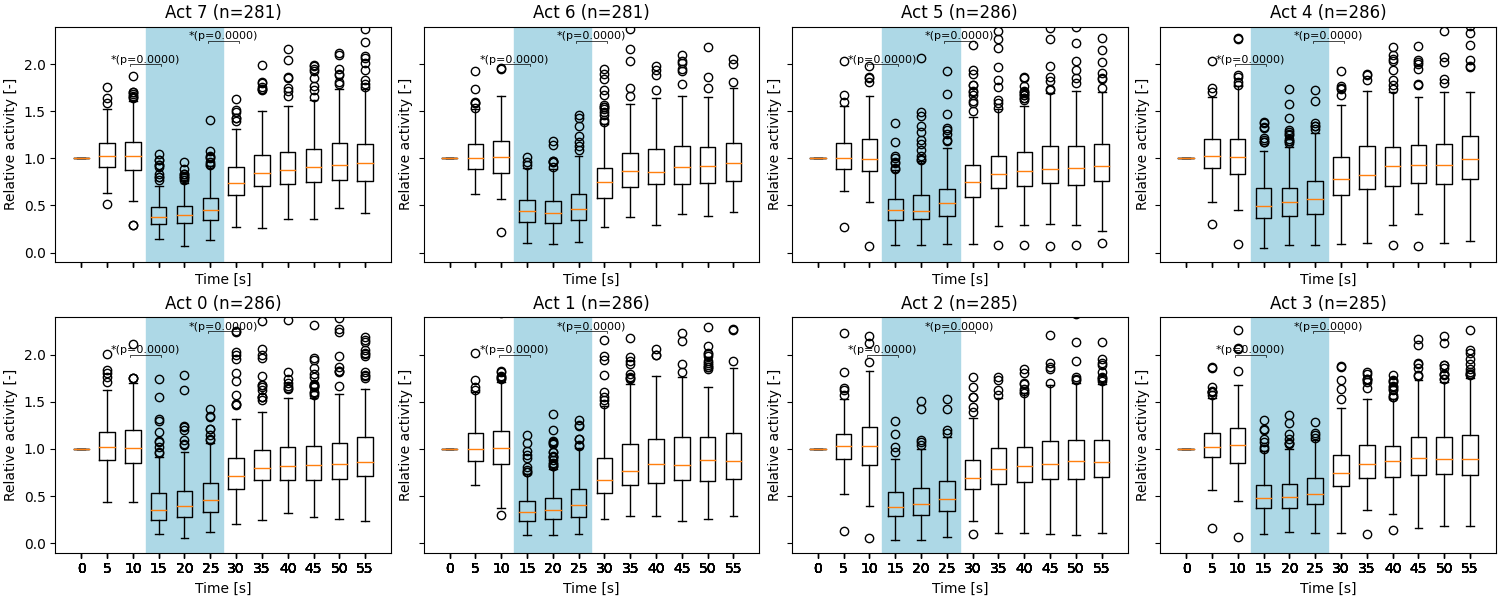

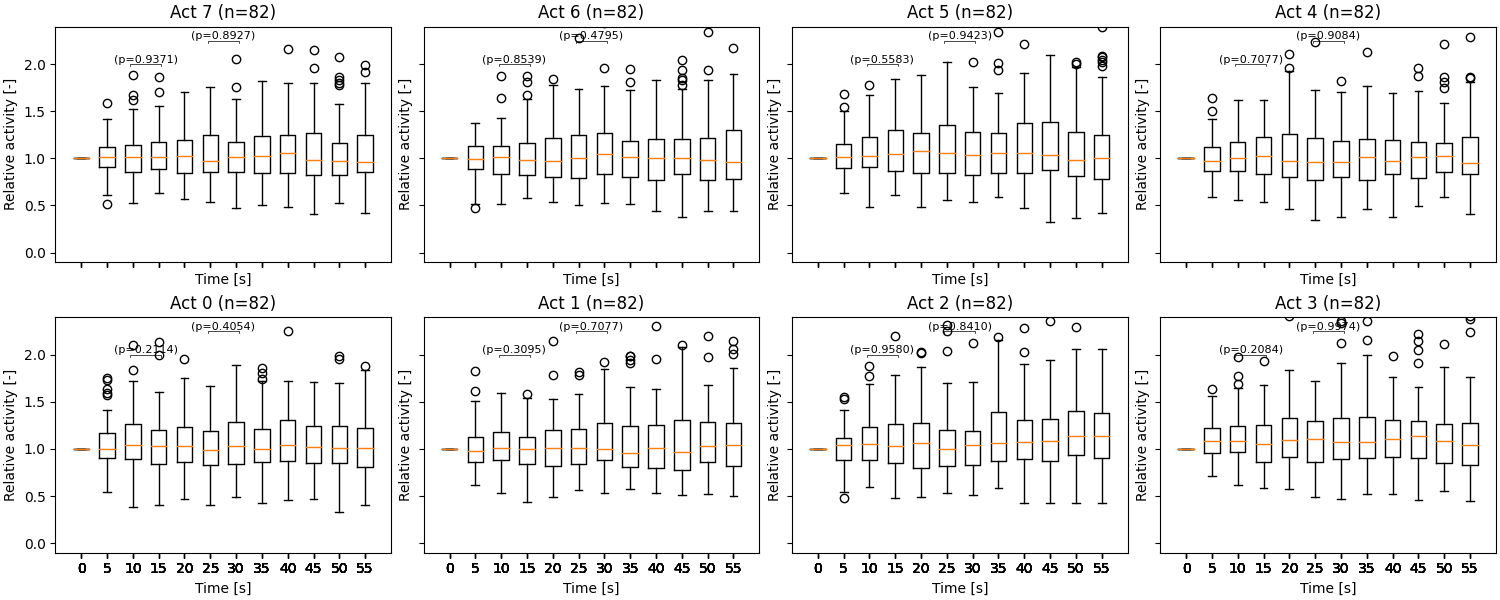

In [8]:
fig, ax = matplotlib.pyplot.subplots(2, 4, figsize=(15, 6), sharex=True, sharey=True, constrained_layout=True)

dataset = data[data.nb_acts_active != 0]

for act in range(NB_ACTS):
    ind = str(act)
    data_to_consider = dataset[dataset['act_z'+ind+'_closest_act_dist'] == 0]

    for j in range(-3, 9):
        _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].boxplot(data_to_consider['z'+ind+'_bin'+str(j+3)+'_rel'].values, positions=[(j+3)*5], widths=[3])

    # Stat tests
    RStest_in   = scipy.stats.ranksums(data_to_consider['z'+ind+'_bin'+str(2)+'_rel'], data_to_consider['z'+ind+'_bin'+str(3)+'_rel'])
    RStest_out  = scipy.stats.ranksums(data_to_consider['z'+ind+'_bin'+str(5)+'_rel'], data_to_consider['z'+ind+'_bin'+str(6)+'_rel'])
    # print(ind, RStest_in[1], RStest_out[1], len(dataset['z'+ind+'_bin'+str(2)+'_rel']))


    if NORMALIZATION_TYPE == 'first':
        YLIMS       = [-0.1, 2.4]
        SB_LEVEL1   = 2.0
        SB_LEVEL2   = 2.25
    else :
        YLIMS       = [-0.1, 1.4]
        SB_LEVEL1   = 1.1
        SB_LEVEL2   = 1.25

    # axis limits
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_xlim([-5, 60])
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_ylim(YLIMS)

    # Actuation marker
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].fill_betweenx(YLIMS, [12.5], [27.5], color='lightblue')

    # axis labels
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_xlabel('Time [s]')
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_ylabel('Relative activity [-]')
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].title.set_text('Act '+ind+' (n={})'.format(len(data_to_consider['z'+ind+'_bin'+str(2)+'_rel'])))

    # Significance bars
    sb_level    = SB_LEVEL1
    sb_width    = 6
    sb_height   = 0.02
    sb_positions= 12.5
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].plot([sb_positions-sb_width/2, sb_positions-sb_width/2, sb_positions+sb_width/2, sb_positions+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].text(sb_positions, sb_level+0.015, '{}(p={:1.4f})'.format(['' if  RStest_in[1]>0.05 else '*'][0], RStest_in[1]), fontsize=8, horizontalalignment='center')

    sb_level    = SB_LEVEL2
    sb_width    = 6
    sb_height   = 0.02
    sb_positions= 27.5
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].plot([sb_positions-sb_width/2, sb_positions-sb_width/2, sb_positions+sb_width/2, sb_positions+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].text(sb_positions, sb_level+0.015, '{}(p={:1.4f})'.format(['' if  RStest_out[1]>0.05 else '*'][0], RStest_out[1]), fontsize=8, horizontalalignment='center')


# Control plot
fig, ax = matplotlib.pyplot.subplots(2, 4, figsize=(15, 6), sharex=True, sharey=True, constrained_layout=True)

dataset = data[data.nb_acts_active == 0]

for act in range(NB_ACTS):
    ind = str(act)
    data_to_consider = dataset[dataset['act_z'+ind+'_closest_act_dist'] == 0]

    for j in range(-3, 9):
        _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].boxplot(dataset['z'+ind+'_bin'+str(j+3)+'_rel'].values, positions=[(j+3)*5], widths=[3])

    # Stat tests
    RStest_in   = scipy.stats.ranksums(dataset['z'+ind+'_bin'+str(2)+'_rel'], dataset['z'+ind+'_bin'+str(3)+'_rel'])
    RStest_out  = scipy.stats.ranksums(dataset['z'+ind+'_bin'+str(5)+'_rel'], dataset['z'+ind+'_bin'+str(6)+'_rel'])
    # print(ind, RStest_in[1], RStest_out[1], len(dataset['z'+ind+'_bin'+str(2)+'_rel']))

    if NORMALIZATION_TYPE == 'first':
        YLIMS       = [-0.1, 2.4]
        SB_LEVEL1   = 2.0
        SB_LEVEL2   = 2.25
    else :
        YLIMS       = [-0.1, 1.4]
        SB_LEVEL1   = 1.1
        SB_LEVEL2   = 1.25

    # axis limits
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_xlim([-5, 60])
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_ylim(YLIMS)

    # axis labels
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_xlabel('Time [s]')
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_ylabel('Relative activity [-]')
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].title.set_text('Act '+ind+' (n={})'.format(len(dataset['z'+ind+'_bin'+str(2)+'_rel'])))

    # Significance bars
    sb_level    = SB_LEVEL1
    sb_width    = 6
    sb_height   = 0.02
    sb_positions= 12.5
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].plot([sb_positions-sb_width/2, sb_positions-sb_width/2, sb_positions+sb_width/2, sb_positions+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].text(sb_positions, sb_level+0.015, '{}(p={:1.4f})'.format(['' if  RStest_in[1]>0.05 else '*'][0], RStest_in[1]), fontsize=8, horizontalalignment='center')

    sb_level    = SB_LEVEL2
    sb_width    = 6
    sb_height   = 0.02
    sb_positions= 27.5
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].plot([sb_positions-sb_width/2, sb_positions-sb_width/2, sb_positions+sb_width/2, sb_positions+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].text(sb_positions, sb_level+0.015, '{}(p={:1.4f})'.format(['' if  RStest_out[1]>0.05 else '*'][0], RStest_out[1]), fontsize=8, horizontalalignment='center')


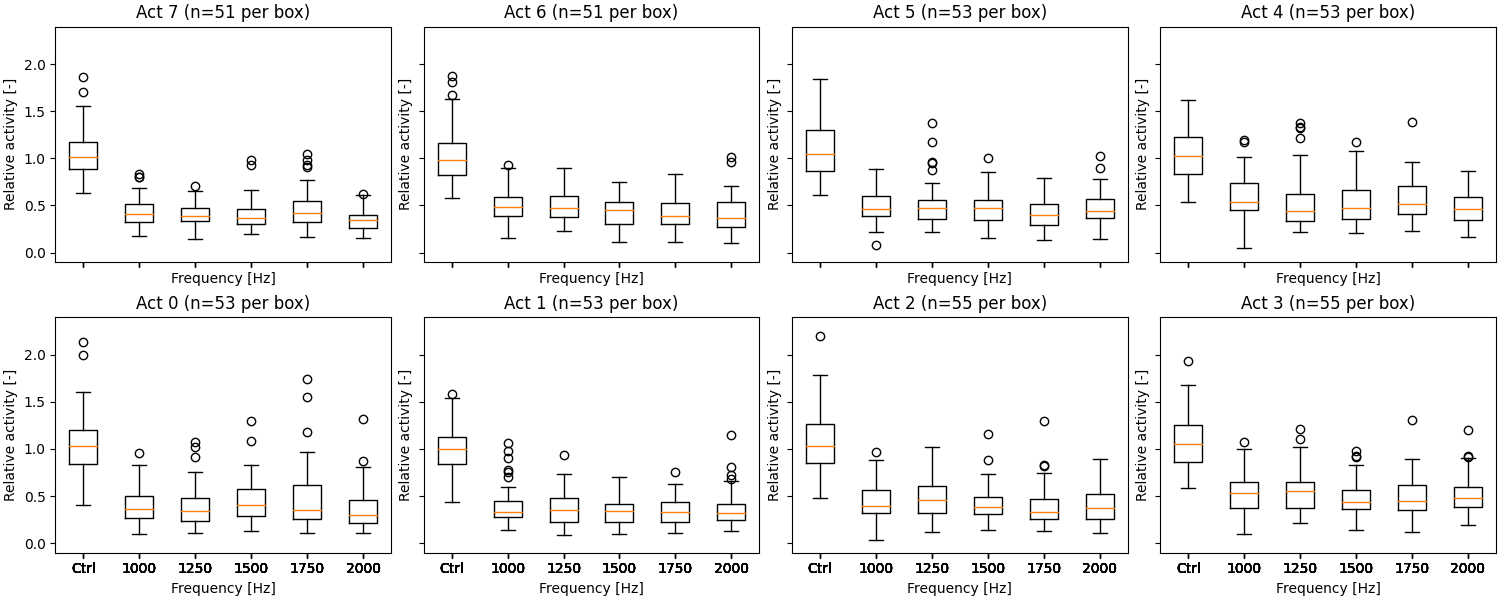

In [9]:
# Frequency-wise plots
frequencies = list(data.frequency.unique())
frequencies.remove('Ctrl')
frequencies = ['Ctrl']+sorted(frequencies)

dataset = data

# distance = 1
fig, ax = matplotlib.pyplot.subplots(2, 4, figsize=(15, 6), sharex=True, sharey=True, constrained_layout=True)
for act in range(NB_ACTS):
    ind = str(act)
    data_to_consider = dataset[dataset['act_z'+ind+'_closest_act_dist'] == 0]

    boxes = []
    for freq in frequencies:
        if freq=='Ctrl':
            data_to_consider_freq = dataset[dataset.frequency == freq]
        else :
            data_to_consider_freq = data_to_consider[data_to_consider.frequency == freq]
        boxes.append(data_to_consider_freq['z'+ind+'_bin3_rel'].values)

    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].boxplot(boxes, positions=range(len(frequencies)), labels=frequencies)

    # Stat tests
    # RStest_in   = scipy.stats.ranksums(dataset['z'+ind+'_bin'+str(2)+'_rel'], dataset['z'+ind+'_bin'+str(3)+'_rel'])
    # RStest_out  = scipy.stats.ranksums(dataset['z'+ind+'_bin'+str(5)+'_rel'], dataset['z'+ind+'_bin'+str(6)+'_rel'])
    # print(ind, RStest_in[1], RStest_out[1], len(dataset['z'+ind+'_bin'+str(2)+'_rel']))

    if NORMALIZATION_TYPE == 'first':
        YLIMS       = [-0.1, 2.4]
    else :
        YLIMS       = [-0.1, 1.4]


    # axis limits
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_xlim([-0.5, 5.5])
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_ylim(YLIMS)

    # axis labels
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_xlabel('Frequency [Hz]')
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].set_ylabel('Relative activity [-]')
    _ = ax[MAPPING_PLOT[act][0], MAPPING_PLOT[act][1]].title.set_text('Act '+ind+' (n={} per box)'.format(len(data_to_consider_freq['z'+ind+'_bin3_rel'])))



KstestResult(statistic=0.4310026044255353, pvalue=6.498788927084709e-19)
179
KstestResult(statistic=0.31489406556340255, pvalue=6.977974864597059e-10)
265
Test (1000 VS 1250) : Value 0.03910620629370629, p-value 0.303448098907279, n 1280
Test (1000 VS 1500) : Value 0.10029788669064749, p-value 1.139380215886554e-05, n 1280
Test (1000 VS 1750) : Value 0.11968529929577465, p-value 5.649067080781833e-08, n 1280
Test (1000 VS 2000) : Value 0.14428191489361702, p-value 2.3454460595928595e-11, n 1280
Test (1250 VS 1500) : Value 0.10751748251748251, p-value 3.865440317274427e-06, n 1144
Test (1250 VS 1750) : Value 0.12419974391805377, p-value 3.9431090947950054e-08, n 1144
Test (1250 VS 2000) : Value 0.1485704012299757, p-value 2.0648149856583586e-11, n 1144
Test (1500 VS 1750) : Value 0.02951160198601682, p-value 0.6957159749005437, n 1112
Test (1500 VS 2000) : Value 0.049632634318077455, p-value 0.12088949739164201, n 1112
Test (1750 VS 2000) : Value 0.03838277894316252, p-value 0.361605547

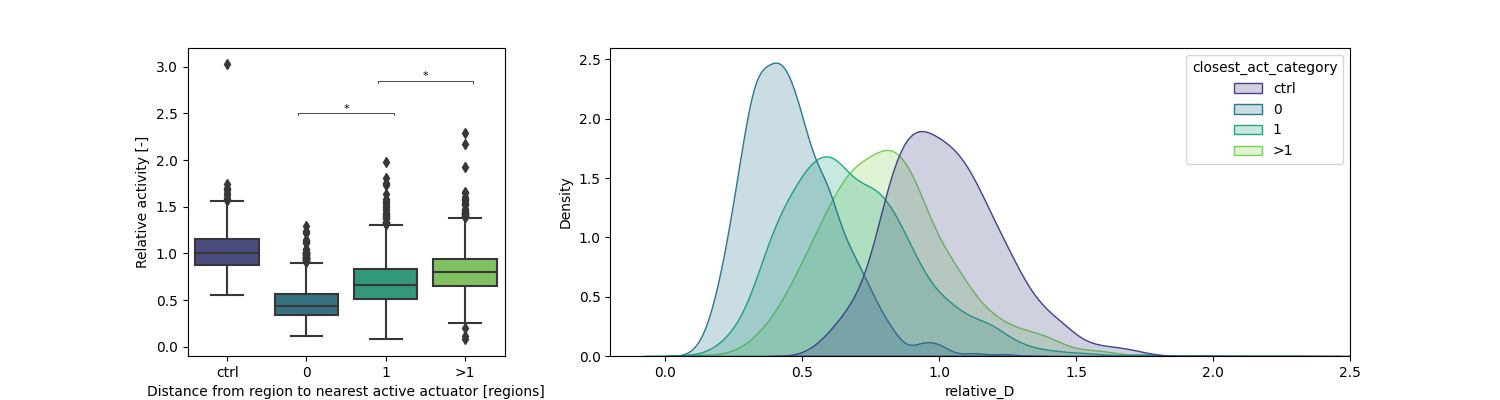

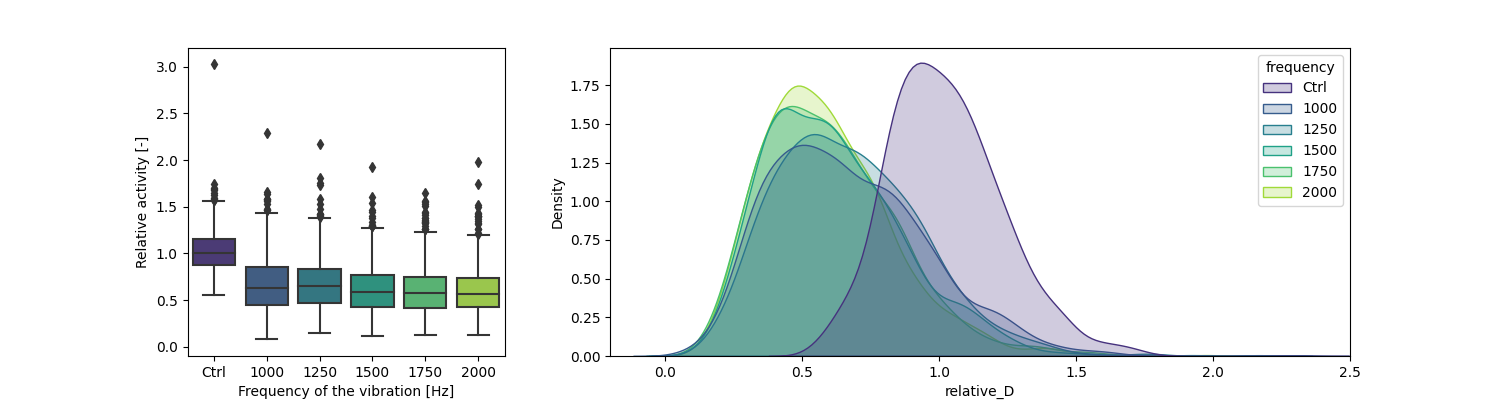

In [10]:
data_complete = []
for exp_id, exp in data.iterrows():
    for act in range(8):
        ind = str(act)

        dp = {}
        dp['time']      = exp.time 
        dp['time_hr']   = exp.time_hr 
        dp['frequency'] = exp.frequency 
        dp['trig0']     = exp.trig0 
        dp['trig1']     = exp.trig1 

        dp['nb_acts_active']    = exp.nb_acts_active
        dp['act']               = exp['act_z'+ind] 
        dp['closest_act_dist']  = exp['act_z'+ind+'_closest_act_dist'] 

        if dp['closest_act_dist'] == 'ctrl':
            dp['closest_act_category'] = dp['closest_act_dist']
        elif dp['closest_act_dist'] <= 1  :
            dp['closest_act_category'] = dp['closest_act_dist']
        else : 
            dp['closest_act_category'] = '>1'

        for key in list(data.columns):
            if key.startswith('z'+ind):
                dp[key[3:]] = exp[key]
        
        data_complete.append(dp)

data_complete = pandas.DataFrame.from_dict(data_complete)

    

fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(15, 4), width_ratios=[30,70])
PALETTE_DIST    = "viridis"
ORDER_DIST      = ['ctrl', 0, 1, '>1']
dataset = data_complete[data_complete.nb_acts_active <= 8]

# data_ctrl           = data[data.frequency == 'Ctrl']['z'+ind+'_relative_D']
# data_dist0          = dataset[dataset.closest_act_dist == 0]['relative_D']
# data_dist1          = dataset[dataset.closest_act_dist == 1]['relative_D']
# data_dist_above1    = dataset[dataset.closest_act_dist >  1]['relative_D']

RStest_0_1 = scipy.stats.kstest(data_dist0, data_dist1)
RStest_1_2 = scipy.stats.kstest(data_dist1, data_dist_above1)
print(RStest_0_1)
print(len(data_dist1))
print(RStest_1_2)
print(len(data_dist_above1))

_ = seaborn.boxplot(data=dataset, x='closest_act_category', y='relative_D', order=ORDER_DIST, palette=PALETTE_DIST, ax=ax[0])
_ = seaborn.kdeplot(data=data_complete, x='relative_D', hue='closest_act_category', hue_order=ORDER_DIST, common_norm=False, fill=True, palette=PALETTE_DIST, ax=ax[1])#, bw_adjust=0.25)
# axis limits
YLIMS = [-0.1, 3.2]
_ = ax[0].set_xlim([-0.5, 3.5])
_ = ax[0].set_ylim(YLIMS)
_ = ax[1].set_xlim([-0.2, 2.5])
# axis labels
_ = ax[0].set_xlabel('Distance from region to nearest active actuator [regions]')
_ = ax[0].set_ylabel('Relative activity [-]')
# Significance bars
sb_level    = 2.5
sb_width    = 1.2
sb_height   = 0.02
sb_positions= 1.5
_ = ax[0].plot([sb_positions-sb_width/2, sb_positions-sb_width/2, sb_positions+sb_width/2, sb_positions+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[0].text(sb_positions, sb_level+0.015, '{}'.format(['' if  RStest_0_1[1]>0.05 else '*'][0], RStest_0_1[1]), fontsize=8, horizontalalignment='center')

sb_level    = 2.85
sb_width    = 1.2
sb_height   = 0.02
sb_positions= 2.5
_ = ax[0].plot([sb_positions-sb_width/2, sb_positions-sb_width/2, sb_positions+sb_width/2, sb_positions+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[0].text(sb_positions, sb_level+0.015, '{}'.format(['' if  RStest_1_2[1]>0.05 else '*'][0], RStest_1_2[1]), fontsize=8, horizontalalignment='center')




# frequency plots
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(15, 4), width_ratios=[30,70])
PALETTE_FREQ    = "viridis"
ORDER_FREQ      = ['Ctrl', 1000, 1250, 1500, 1750, 2000]
_ = seaborn.boxplot(data=dataset, x='frequency', y='relative_D', order=ORDER_FREQ, ax=ax[0], palette=PALETTE_FREQ)
_ = seaborn.kdeplot(data=data_complete, x='relative_D', hue='frequency', hue_order=ORDER_FREQ, common_norm=False, fill=True, ax=ax[1], palette=PALETTE_FREQ)
# axis limits
_ = ax[0].set_xlim([-0.5, 5.5])
_ = ax[0].set_ylim(YLIMS)
_ = ax[1].set_xlim([-0.2, 2.5])
# axis labels
_ = ax[0].set_xlabel('Frequency of the vibration [Hz]')
_ = ax[0].set_ylabel('Relative activity [-]')

# stats
for i, freq_i in enumerate(ORDER_FREQ):
    if freq_i == 'Ctrl':
        continue
    for j, freq_j in enumerate(ORDER_FREQ):
        if freq_j == 'Ctrl':
            continue
        if j <= i:
            continue
        RS = scipy.stats.kstest(dataset[dataset.frequency == freq_i].relative_D, dataset[dataset.frequency == freq_j].relative_D)
        print('Test ({} VS {}) : Value {}, p-value {}, n {}'.format(freq_i, freq_j, RS[0], RS[1], len(dataset[dataset.frequency == freq_i].relative_D)))
        

# sb_level    = 2.85
# sb_width    = 4.2
# sb_height   = 0.02
# sb_positions= 3
# _ = ax[0].plot([sb_positions-sb_width/2, sb_positions-sb_width/2, sb_positions+sb_width/2, sb_positions+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
# _ = ax[0].text(sb_positions, sb_level+0.015, 'N.S.', fontsize=8, horizontalalignment='center')

In [11]:
print(seaborn.color_palette("viridis", 8).as_hex())

['#482878', '#3e4989', '#31688e', '#26828e', '#1f9e89', '#35b779', '#6ece58', '#b5de2b']


In [12]:
data_complete.closest_act_category.unique()

array([1, 0, '>1', 'ctrl'], dtype=object)

In [13]:
scipy.stats.kstest(numpy.random.random(200), numpy.random.random(200))

KstestResult(statistic=0.065, pvalue=0.7933622419382523)